# Linear Interpolation of HRIRs
Please download the HRIR Repository from: [MARL-HRIR-Repository](https://steinhardt.nyu.edu/marl/research/resources/head-related-impulse-responses-repository-0)  
Unzip the downloaded file, the filename should be 'marl_nyu'  
Upload the file to Google Drive, then it can be accessed once your Google Drive is mounted

In [1]:
#@title Setting up
# import packages
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import librosa

# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#@title Data loading

# load data (the index range of the CIPIC dataset is from 52 to 96, totalling 45 participants)
CIPIC_data = []
for file_idx in range(52,97):
  # In my Google Drive, 'marl_nyu' is under the '3D Audio' folder, change the filename below if you have a different directory
  filename = f'/content/drive/MyDrive/3D Audio/marl_nyu/HRIRrepository/S0{file_idx}_marl-nyu.mat'
  CIPIC_data.append(scipy.io.loadmat(filename)['data'][0])

In [3]:
#@title Data processing/visualization class
class hrtf_interp:

  def __init__(self, hrtf_data):

    # CIPIC HRIRs use a sampling rate of 44.1kHz
    self.sample_rate = 44100

    self.points = []
    self.azimuth = []
    self.elevation = []

    for data in hrtf_data:
      data_dict = {}
      data_dict['azimuth'] = data[0].item()
      data_dict['elevation'] = data[1].item()
      if data_dict['elevation'] not in self.elevation:
        self.elevation.append(data_dict['elevation'])
      if data_dict['azimuth'] not in self.azimuth:
        self.azimuth.append(data_dict['azimuth'])
      data_dict['distance'] = data[2].item()
      data_dict['hrir'] = data[3]
      self.points.append(data_dict)
    
    self.azimuth.sort()
    self.elevation.sort()

    self.used_azimuth = self.azimuth[::2]
    self.used_elevation = self.elevation[::2]

    self.interp_data = []
    self._generate_interpolation_data()

  def _generate_interpolation_data(self):

    search_dict = {}
    for azi in self.azimuth:
      search_dict[azi] = {}
    for data_dict in self.points:
      search_dict[data_dict['azimuth']][data_dict['elevation']] = data_dict['hrir']

    for data_dict in self.points:
      if data_dict['azimuth'] not in self.used_azimuth and data_dict['elevation'] not in self.used_elevation:
        point = {}
        azi = data_dict['azimuth']
        ele = data_dict['elevation']
        if ele == 90:
          continue
        point['azimuth'] = azi
        point['elevation'] = ele
        point['ground_truth'] = data_dict['hrir']
        ele_idx = self.elevation.index(ele)
        ele_up = self.elevation[ele_idx+1]
        ele_down = self.elevation[ele_idx-1]
        point['up'] = search_dict[azi][ele_up]
        # use the symmetric data
        if ele_down == -50.625:
          if azi > -100 and azi <= 0:
            azi = -180 - azi
          if azi < 100 and azi > 0:
            azi = 180 - azi
        point['down'] = search_dict[azi][ele_down]
        azi = point['azimuth']
        azi_idx = self.azimuth.index(azi)
        azi_left = self.azimuth[azi_idx-1]
        azi_right = self.azimuth[(azi_idx+1)%len(self.azimuth)]
        if azi == 175:
          point['right_weight'] = 1
        else:
          point['right_weight'] = (azi-azi_left)/(azi_right-azi_left)
        point['left_weight'] = 1 - point['right_weight']
        point['left'] = search_dict[azi_left][ele]
        point['right'] = search_dict[azi_right][ele]
        self.interp_data.append(point)

  def linear_interp(self, X1, X2, method, w1=0.5, w2=0.5):
    if method == 'rec':
      return w1*X1 + w2*X2
    if method == 'polar':
      mag = w1*np.abs(X1) + w2*np.abs(X2)
      phase = w1*np.unwrap(np.angle(X1)) + w2*np.unwrap(np.angle(X2))
      phase = (phase + np.pi) % (2*np.pi) - np.pi
      return mag * np.exp(1j*phase)

  def compute_error(self, X1, X2, keep_freq_dim=False):
    if keep_freq_dim:
      err = np.abs(X1-X2)
      err = err[:1+len(err)//2]
      return self.mel_filterbank @ err
    else:
      return np.linalg.norm(X1-X2)

  def interpolate(self, n_fft=1024, keep_freq_dim=False, n_mels=10):

    if keep_freq_dim:
      self.mel_filterbank = librosa.filters.mel(self.sample_rate, n_fft, n_mels=n_mels)

    for point in self.interp_data:
      
      if keep_freq_dim:
        err = np.zeros([4, n_mels])
      else:
        err = np.zeros([4])

      for channel in range(2):
        ground_truth = np.fft.fft(point['ground_truth'][:,channel], n_fft)
        
        # UP/DOWN (the elevation pair)
        up = np.fft.fft(point['up'][:,channel], n_fft)
        down = np.fft.fft(point['down'][:,channel], n_fft)
        interp1 = self.linear_interp(up, down, 'rec')
        interp2 = self.linear_interp(up, down, 'polar')
        err[0] += self.compute_error(interp1, ground_truth, keep_freq_dim)
        err[1] += self.compute_error(interp2, ground_truth, keep_freq_dim)

        # LEFT/RIGHT (the azimuth pair)
        left = np.fft.fft(point['left'][:,channel], n_fft)
        right = np.fft.fft(point['right'][:,channel], n_fft)
        interp3 = self.linear_interp(left, right, 'rec', w1=point['left_weight'], w2=point['right_weight'])
        interp4 = self.linear_interp(left, right, 'polar', w1=point['left_weight'], w2=point['right_weight'])
        err[2] += self.compute_error(interp3, ground_truth, keep_freq_dim)
        err[3] += self.compute_error(interp4, ground_truth, keep_freq_dim)
      
      point['error'] = err

  def get_dir_error(self):

    azimuth = {}
    elevation = {}
    
    for point in self.interp_data:
      if 'error' not in list(point.keys()):
        print('Please run interpolate() first')
        break
      azi = point['azimuth']
      ele = point['elevation']
      if azi not in list(azimuth.keys()):
        azimuth[azi] = []
      if ele not in list(elevation.keys()):
        elevation[ele] = []
      azimuth[azi].append(point['error'])
      elevation[ele].append(point['error'])

    return azimuth, elevation

  def plot_points(self, azimuth_divide=False, elevation_divide=False):
    
    theta = [[],[]]
    phi = [[],[]]
    r = [[],[]]

    for i in range(len(self.points)):
      col = 0
      if azimuth_divide==True and elevation_divide==False and self.points[i]['azimuth'] not in self.used_azimuth:
        col = 1
      if elevation_divide==True and azimuth_divide==False and self.points[i]['elevation'] not in self.used_elevation:
        col = 1
      if azimuth_divide and elevation_divide and self.points[i]['azimuth'] not in self.used_azimuth and self.points[i]['elevation'] not in self.used_elevation:
        col = 1
      theta[col].append(self.points[i]['azimuth'])
      phi[col].append(self.points[i]['elevation'])
      r[col].append(self.points[i]['distance'])
    
    theta_used = np.array(theta[0]) * np.pi / 180
    phi_used = np.array(phi[0]) * np.pi / 180
    r_used = np.array(r[0])

    x_used = r_used * np.cos(phi_used) * np.cos(theta_used)
    y_used = r_used * np.cos(phi_used) * np.sin(theta_used)
    z_used = r_used * np.sin(phi_used)

    theta_unused = None
    if len(theta[1]) > 0:
      theta_unused = np.array(theta[1]) * np.pi / 180
      phi_unused = np.array(phi[1]) * np.pi / 180
      r_unused = np.array(r[1])
      x_unused = r_unused * np.cos(phi_unused) * np.cos(theta_unused)
      y_unused = r_unused * np.cos(phi_unused) * np.sin(theta_unused)
      z_unused = r_unused * np.sin(phi_unused)

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(projection='3d')

    ax1.scatter(0, 0, 0, color='black', marker='>', s=100, label='listener')
    ax1.scatter(x_used, y_used, z_used, color='b', label='preserved points')
    if theta_unused is not None:
      ax1.scatter(x_unused, y_unused, z_unused, color='magenta', alpha=0.2, label='ground truth')
    ax1.set(xlabel='x axis', ylabel='y axis', zlabel='z axis', title='3D points of HRIR data')
    ax1.legend()
    plt.show()

  def plot_azimuth_and_elevation(self, divide=False):

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6),subplot_kw={'projection': 'polar'})
    for theta in self.azimuth:
      if theta in self.used_azimuth or not divide:
        ax1.plot([theta*np.pi/180]*2, [0,1], c='b')
      else:
        ax1.plot([theta*np.pi/180]*2, [0,1], c='magenta', alpha=.2)
    ax1.scatter(0, 0, color='black', marker='>', s=100, label='listener', zorder=1000)
    
    # replace the degree label by its opposite value, can do this because it's symmetric
    ax1.set_xticklabels(['0'+u'\N{DEGREE SIGN}','-45'+u'\N{DEGREE SIGN}','-90'+u'\N{DEGREE SIGN}','-135'+u'\N{DEGREE SIGN}',
                        '+/-180'+u'\N{DEGREE SIGN}','135'+u'\N{DEGREE SIGN}','90'+u'\N{DEGREE SIGN}','45'+u'\N{DEGREE SIGN}'])
    ax1.set_yticklabels(['']*5)
    ax1.set_title('azimuth')
    ax1.legend()

    for phi in self.elevation:
      if phi in self.used_elevation or not divide:
        ax2.plot([phi*np.pi/180]*2, [0,1], c='b')
      elif phi == 90:
        continue
      else:
        ax2.plot([phi*np.pi/180]*2, [0,1], c='magenta', alpha=.2)
    ax2.scatter(0, 0, color='black', marker='>', s=100, label='listener', zorder=1000)
    ax2.set_xticklabels(['0'+u'\N{DEGREE SIGN}','45'+u'\N{DEGREE SIGN}','90'+u'\N{DEGREE SIGN}','','','','',
                        '-45'+u'\N{DEGREE SIGN}'])
    ax2.set_yticklabels(['']*5)
    ax2.set_title('elevation')
    ax2.legend()

    plt.show()

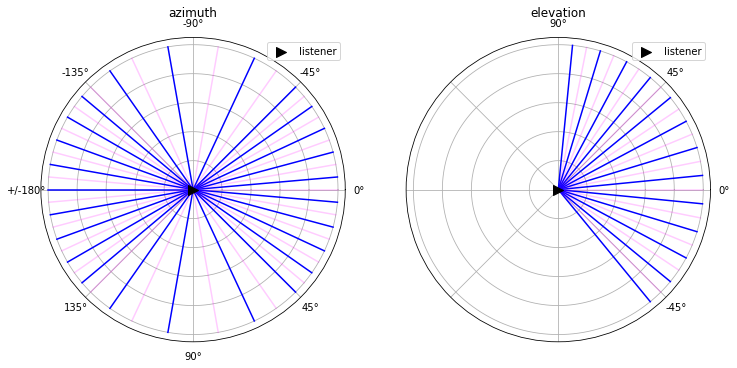

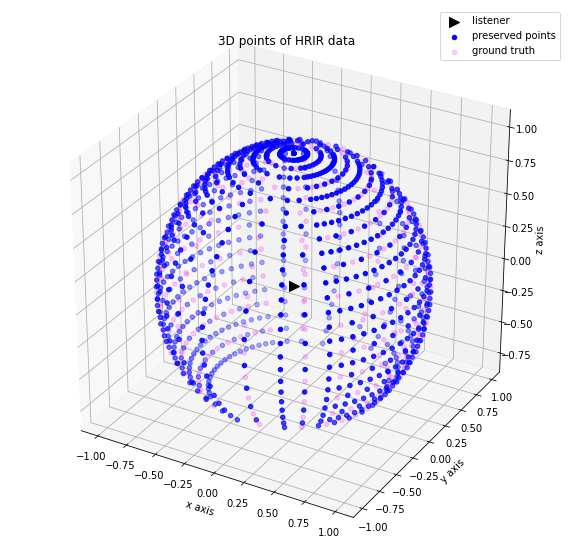

In [4]:
#@title Plot 3D HRIR points, azimuth and elevation in CIPIC
lser = hrtf_interp(CIPIC_data[0])
lser.plot_azimuth_and_elevation(divide=True)
lser.plot_points(azimuth_divide=True, elevation_divide=True)

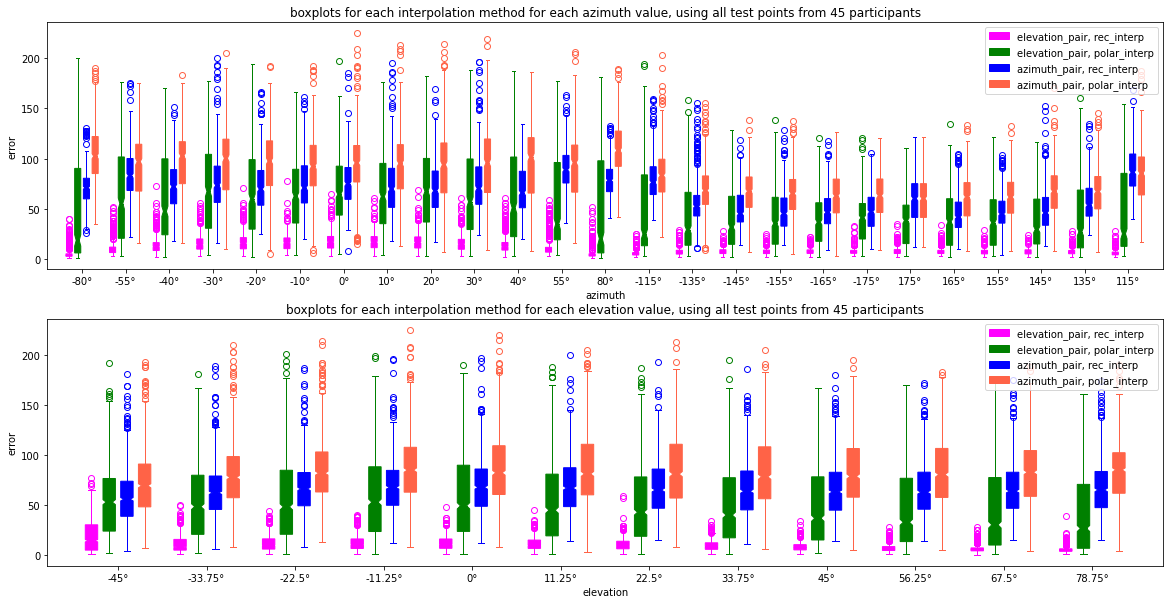

In [5]:
#@title Deconstruct the error by interpolation method, azimuth, and elevation

lser = hrtf_interp(CIPIC_data[0])
lser.interpolate()
azi_err, ele_err = lser.get_dir_error()
for i in range(1,len(CIPIC_data)):
  lser = hrtf_interp(CIPIC_data[i])
  lser.interpolate()
  azi_err_temp, ele_err_temp = lser.get_dir_error()
  for k, v in azi_err_temp.items():
    azi_err[k] = azi_err[k] + v
  for k, v in ele_err_temp.items():
    ele_err[k] = ele_err[k] + v
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,10))
width = 0.2
azi_label = []
err_mtx = []
for azi, err in azi_err.items():
  err = np.array(err)
  azi_label.append(str(azi)+u'\N{DEGREE SIGN}')
  err_mtx.append(err)
err_mtx = np.array(err_mtx)
err_mtx = np.swapaxes(err_mtx, 0, 1)
br1 = np.arange(err_mtx.shape[1])
br2 = [x + width for x in br1]
br3 = [x + width for x in br2]
br4 = [x + width for x in br3]
c = ['magenta', 'g', 'b', 'tomato']
labels = ['elevation_pair, rec_interp', 'elevation_pair, polar_interp',
           'azimuth_pair, rec_interp', 'azimuth_pair, polar_interp']
bp1 = ax1.boxplot(err_mtx[:,:,0], widths=width*0.7, positions=br1, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[0], color=c[0]), capprops=dict(color=c[0]), whiskerprops=dict(color=c[0]),
                  flierprops=dict(color=c[0], markeredgecolor=c[0]),medianprops=dict(color=c[0]))
bp2 = ax1.boxplot(err_mtx[:,:,1], widths=width*0.7, positions=br2, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[1], color=c[1]), capprops=dict(color=c[1]), whiskerprops=dict(color=c[1]),
                  flierprops=dict(color=c[1], markeredgecolor=c[1]),medianprops=dict(color=c[1]))
bp3 = ax1.boxplot(err_mtx[:,:,2], widths=width*0.7, positions=br3, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[2], color=c[2]), capprops=dict(color=c[2]), whiskerprops=dict(color=c[2]),
                  flierprops=dict(color=c[2], markeredgecolor=c[2]),medianprops=dict(color=c[2]))
bp4 = ax1.boxplot(err_mtx[:,:,3], widths=width*0.7, positions=br4, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[3], color=c[3]), capprops=dict(color=c[3]), whiskerprops=dict(color=c[3]),
                  flierprops=dict(color=c[3], markeredgecolor=c[3]),medianprops=dict(color=c[3]))
ax1.set_xlabel('azimuth')
ax1.set_ylabel('error')
ax1.set_xticks([r + width*1.5 for r in range(err_mtx.shape[1])])
ax1.set_xticklabels(azi_label)
ax1.set_title('boxplots for each interpolation method for each azimuth value, using all test points from 45 participants')
ax1.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], labels)
ele_label = []
err_mtx = []
for ele, err in ele_err.items():
  err = np.array(err)
  ele_label.append(str(ele)+u'\N{DEGREE SIGN}')
  err_mtx.append(err)
err_mtx = np.array(err_mtx)
err_mtx = np.swapaxes(err_mtx, 0, 1)
br1 = np.arange(err_mtx.shape[1])
br2 = [x + width for x in br1]
br3 = [x + width for x in br2]
br4 = [x + width for x in br3]
bp1 = ax2.boxplot(err_mtx[:,:,0], widths=width*0.7, positions=br1, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[0], color=c[0]), capprops=dict(color=c[0]), whiskerprops=dict(color=c[0]),
                  flierprops=dict(color=c[0], markeredgecolor=c[0]),medianprops=dict(color=c[0]))
bp2 = ax2.boxplot(err_mtx[:,:,1], widths=width*0.7, positions=br2, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[1], color=c[1]), capprops=dict(color=c[1]), whiskerprops=dict(color=c[1]),
                  flierprops=dict(color=c[1], markeredgecolor=c[1]),medianprops=dict(color=c[1]))
bp3 = ax2.boxplot(err_mtx[:,:,2], widths=width*0.7, positions=br3, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[2], color=c[2]), capprops=dict(color=c[2]), whiskerprops=dict(color=c[2]),
                  flierprops=dict(color=c[2], markeredgecolor=c[2]),medianprops=dict(color=c[2]))
bp4 = ax2.boxplot(err_mtx[:,:,3], widths=width*0.7, positions=br4, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[3], color=c[3]), capprops=dict(color=c[3]), whiskerprops=dict(color=c[3]),
                  flierprops=dict(color=c[3], markeredgecolor=c[3]),medianprops=dict(color=c[3]))
ax2.set_xlabel('elevation')
ax2.set_ylabel('error')
ax2.set_xticks([r + width*1.5 for r in range(err_mtx.shape[1])])
ax2.set_xticklabels(ele_label)
ax2.set_title('boxplots for each interpolation method for each elevation value, using all test points from 45 participants')
ax2.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], labels)
plt.show()

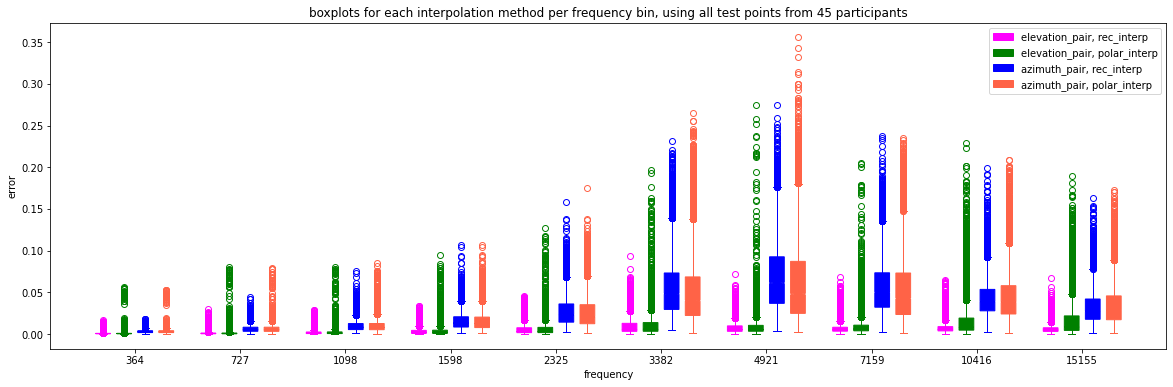

In [6]:
#@title Deconstruct the error by interpolation method and frequency

err_mtx = []
for data in CIPIC_data:
  lser = hrtf_interp(data)
  lser.interpolate(keep_freq_dim=True)
  for point in lser.interp_data:
    err_mtx.append(point['error'])
err_mtx = np.array(err_mtx)
fig, ax = plt.subplots(figsize=(20,6))
width = 0.2
c = ['magenta', 'g', 'b', 'tomato']
labels = ['elevation_pair, rec_interp', 'elevation_pair, polar_interp',
           'azimuth_pair, rec_interp', 'azimuth_pair, polar_interp']
xtick_label = list(librosa.mel_frequencies(n_mels=12, fmax=44100/2))
xtick_label = [str(int(np.round(x))) for x in xtick_label]
br1 = np.arange(err_mtx.shape[2])
br2 = [x + width for x in br1]
br3 = [x + width for x in br2]
br4 = [x + width for x in br3]
bp1 = ax.boxplot(err_mtx[:,0,:], widths=width*0.7, positions=br1, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[0], color=c[0]), capprops=dict(color=c[0]), whiskerprops=dict(color=c[0]),
                  flierprops=dict(color=c[0], markeredgecolor=c[0]),medianprops=dict(color=c[0]))
bp2 = ax.boxplot(err_mtx[:,1,:], widths=width*0.7, positions=br2, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[1], color=c[1]), capprops=dict(color=c[1]), whiskerprops=dict(color=c[1]),
                  flierprops=dict(color=c[1], markeredgecolor=c[1]),medianprops=dict(color=c[1]))
bp3 = ax.boxplot(err_mtx[:,2,:], widths=width*0.7, positions=br3, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[2], color=c[2]), capprops=dict(color=c[2]), whiskerprops=dict(color=c[2]),
                  flierprops=dict(color=c[2], markeredgecolor=c[2]),medianprops=dict(color=c[2]))
bp4 = ax.boxplot(err_mtx[:,3,:], widths=width*0.7, positions=br4, notch=True, patch_artist=True,
                  boxprops=dict(facecolor=c[3], color=c[3]), capprops=dict(color=c[3]), whiskerprops=dict(color=c[3]),
                  flierprops=dict(color=c[3], markeredgecolor=c[3]),medianprops=dict(color=c[3]))
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], labels)
ax.set_xticks([r + width*1.5 for r in range(err_mtx.shape[2])])
ax.set_xticklabels(xtick_label[1:-1])
ax.set_xlabel('frequency')
ax.set_ylabel('error')
ax.set_title('boxplots for each interpolation method per frequency bin, using all test points from 45 participants')
plt.show()

## Results

Interpolation methods:  
>Using elevation pair is better than using azimuth pair  
>Rectangular interpolation is better than polar interpolation

Azimuth:
>Less error when interpolating behind the body

Frequency:
>Less error at lower frequencies